In [14]:
import os
import numpy as np
import pandas as pd

from six import iteritems

from io import open
import unicodedata
import string
import re
import random
import pickle
import spacy
nlp = spacy.load('en')

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

%matplotlib inline

In [2]:

def read_sentence_embeddings_jw( pathname ):
    '''Read John Wieting sentence embeddings'''
    with open(pathname , 'rb') as f:
        # [ numpy.ndarray(95283, 300), numpy.ndarray(74664, 300), (trigram_dict, word_dict)]
        x = pickle.load(f, encoding='latin1')
        word_vocab_size, embedding_size = x[1].shape
        trigram_embeddings, word_embeddings, _ = x
        
        trigram_to_id, word_to_id = x[2]
        word_to_id['<START>'] = word_vocab_size
        word_to_id['<END>'] = word_vocab_size + 1
        idx_to_word = { idx: word for word, idx in iteritems(word_to_id) }
        word_embeddings = np.vstack((word_embeddings, np.random.randn(2, embedding_size)))

        return ( word_to_id, 
                 idx_to_word, 
                 word_embeddings, 
                 word_to_id['<START>'], 
                 word_to_id['<END>'], 
                 word_to_id['UUUNKKK'], 
                 word_to_id['★']
               )
    

pathname='../rec/data/ngram-word-concat-40.pickle'
word_to_id, id_to_word, embeddings, start_id, end_id, unk_id, mask_id = read_sentence_embeddings_jw( pathname )

print( [ (word_to_id[id_to_word[i]], id_to_word[i]) for i in range(10) ] )
print( len(word_to_id) )
print( embeddings.shape )



[(0, ','), (1, '.'), (2, 'the'), (3, 'and'), (4, 'to'), (5, 'of'), (6, 'a'), (7, 'in'), (8, ':'), (9, 'is')]
74602
(74666, 300)


In [3]:


class Dictionary:
    def __init__(self ):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0
        self.embeddings = []
        
        self.PAD_token = 0  # Used for padding short sentences
        self.SOS_token = 1  # Start-of-sentence token
        self.EOS_token = 2  # End-of-sentence token
        self.UNK_token = 3 


    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def load_embeddings_jw( self, pathname ):
        '''Read John Wieting sentence embeddings'''
        with open(pathname , 'rb') as f:
            # [ numpy.ndarray(95283, 300), numpy.ndarray(74664, 300), (trigram_dict, word_dict)]
            x = pickle.load(f, encoding='latin1')
            
            word_vocab_size, embedding_size = x[1].shape
            trigram_embeddings, word_embeddings, _ = x

            trigram_to_id, word_to_id = x[2]
            
            word_to_id['<START>'] = word_vocab_size
            word_to_id['<END>']   = word_vocab_size + 1
                                   
            idx_to_word = { idx: word for word, idx in iteritems(word_to_id) }
            word_embeddings = np.vstack((word_embeddings, np.random.randn(2, embedding_size)))
            word_to_count = { word: 1 for word, idx in iteritems(word_to_id) }
            
            self.word2index = word_to_id
            self.index2word = idx_to_word
            self.word2count = word_to_count
            self.embeddings = word_embeddings
            self.n_words    = len(word_to_id)
            
            self.PAD_token = word_to_id['★']        # Used for padding short sentences
            self.SOS_token = word_to_id['<START>']  # Start-of-sentence token
            self.EOS_token = word_to_id['<END>']    # End-of-sentence token
            self.UNK_token = word_to_id['UUUNKKK'] 


pathname='../rec/data/ngram-word-concat-40.pickle'
dictionaty = Dictionary()
dictionaty.load_embeddings_jw( pathname )
print( len(dictionaty.word2index) )
print( len(dictionaty.index2word) )
print( len(dictionaty.word2count) )
print( dictionaty.embeddings.shape )



74602
74602
74602
(74666, 300)


In [4]:


def openmp_nlp_pipeline(lines, n_threads=12):
    ''' Execute spacy's openmp nlp pipeline '''
    return [ [ token.lower_ for token in doc ] for doc in nlp.pipe(lines, n_threads=n_threads, disable=['parser', 'tagger', 'ner']) ]


# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def read_paraphraser( pathname ):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(pathname, encoding='utf-8').\
        read().strip().split('\n')    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]    # normalizeString, openmp_nlp_pipeline,
        
#     source_sentences = []
#     ref_sentences = []    
#     with open(pathname, 'r') as f:
#         for i, line in enumerate(f):
#             source, ref = line.split('\t')
#             source_sentences.append(source.strip())
#             ref_sentences.append(ref.strip())    
#     source_sentences = openmp_nlp_pipeline( source_sentences )
#     ref_sentences = openmp_nlp_pipeline( ref_sentences )
#     pairs = np.stack( ( source_sentences, ref_sentences), axis=1 )    
    
    return pairs


pathname = '../rec/data/para-nmt-50m-small.txt'
pairs = read_paraphraser( pathname )
print( pairs[1] )



Reading lines...
['of course you did .', 'of course it is .']


In [5]:
MAX_LENGTH = 10

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [6]:

def prepare_data( pathname, pathdictionary ):
    pairs = read_paraphraser( pathname)
    dictionary = Dictionary()
    dictionary.load_embeddings_jw( pathdictionary )
    
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
        
    print("Counted words:")
    print(dictionary.n_words)
    return dictionary, pairs


pathname = '../rec/data/para-nmt-50m-small.txt'
pathdictionary = '../rec/data/ngram-word-concat-40.pickle'

dictionary, pairs = prepare_data( pathname, pathdictionary )

# print(random.choice(pairs))
print(len(pairs))
for pair in pairs[:10]:
    print(pair)
    
    

Reading lines...
Read 99968 sentence pairs
Counted words:
74602
44299
['of course you did .', 'of course it is .']
[' why not ?', ' why not ?']
['an old man s mistake ', 'an old man s fault . . . ']
['he loved that little man by the way .', 'he liked the little boy .']
['provide the following information', 'enter the following information']
['i ve been very very lucky .', 'i was just lucky .']
['why are you carrying around grass ?', 'why did you pull the grass ?']
['not as much as i d like', 'not as often as i d like .']
['i do n t like that crap .', 'i do n t like it .']
['from a marine in da nang ', 'from the sailor in da nang .']


In [7]:

import itertools

def indexesFromSentence(voc, sentence):
    return [voc.word2index.get(word, voc.UNK_token )  for word in sentence.split(' ')] + [ voc.EOS_token ]

def zeroPadding(l, fillvalue):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == value:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch, voc.EOS_token)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch, voc.EOS_token)
    mask = binaryMatrix(padList, voc.EOS_token)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len


def get_triplets( pairs ):
    n = len(pairs)
    i = np.arange( n )
    j = np.arange( n )
    while np.sum( (np.abs(i-j) == 0 ) ) != 0:
        random.shuffle( j )
    #pairs = [ pairs[x] for x in j ]  
    #p = [ x[ random.randint( 0,1 ) ] for x in pairs  ]    
    triplets = [ ((pairs[i][0], pairs[i][1], pairs[j[i]][ random.randint( 0,1 ) ]))  for i in range(n) ]    
    return triplets

# Returns all items for a given batch of pairs
def batch2TrainData( dictionary , pair_batch):
    
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    triple_batch = get_triplets(pair_batch)
    s1_batch, s2_batch, t1_batch = [], [], []
    for triple in triple_batch :
        s1_batch.append(triple[0])
        s2_batch.append(triple[1])
        t1_batch.append(triple[2])
    #inp, lengths = inputVar(input_batch, dictionary)
    #output, mask, max_target_len = outputVar(output_batch, dictionary)    
    s1, s1_mask, s1_max_len = outputVar(s1_batch, dictionary)
    s2, s2_mask, s2_max_len = outputVar(s2_batch, dictionary)
    t1, t1_mask, t1_max_len = outputVar(t1_batch, dictionary)    
    return s1, s1_mask, s1_max_len, s2, s2_mask, s2_max_len, t1, t1_mask, t1_max_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData( dictionary, [random.choice(pairs) for _ in range(small_batch_size)] )
s1, s1_mask, s1_max_len, s2, s2_mask, s2_max_len, t1, t1_mask, t1_max_len = batches

print("s1_variable:", s1)
print("lengths:", s1_max_len)
print("mask:", s1_mask)

print("s2_variable:", s2)
print("lengths:", s2_max_len)
print("mask:", s2_mask)

print("t1_variable:", t1)
print("lengths:", t1_max_len)
print("mask:", t1_mask)



s1_variable: tensor([[     2,     17,     49,  74663,      2],
        [  8696,    103,     28,  18765,  14788],
        [    18,     42,     17,   7455,    205],
        [     2,   3345,      1,      1,   6801],
        [  1139,   5306,  74665,  74665,  74665],
        [    35,     35,  74665,  74665,  74665],
        [ 74665,  74665,  74665,  74665,  74665]])
lengths: 7
mask: tensor([[ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1],
        [ 1,  1,  0,  0,  0],
        [ 1,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0]], dtype=torch.uint8)
s2_variable: tensor([[ 64406,     45,      3,  74663,   3121],
        [    18,     17,     49,   7297,  14788],
        [     2,    103,      5,    234,  74665],
        [  1139,     42,    164,  18765,  74665],
        [    35,    743,    703,   3710,  74665],
        [ 74665,   5306,     28,      1,  74665],
        [ 74665,     35,     17,  74665,  74665],
        [ 74665,  74665,  

## Encoder 

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

    
class EncoderAvg(nn.Module):
    def __init__(self, embedding, tonorm=True):
        super(EncoderAvg, self).__init__()
        self.embedding = embedding      
        self.tonorm = tonorm

    def forward(self, input_seq, input_mask ):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)        
        #Average
        outputs = (embedded * input_mask.view( input_mask.shape[0],input_mask.shape[1],-1 ).float())  
        outputs = outputs.sum( dim=0 ) 
        if self.tonorm: 
            outputs = outputs / input_mask.float().sum(dim=0).unsqueeze(dim=1)        
        return outputs
    
    
class Tripletnet(nn.Module):
    def __init__(self, embeddingnet):
        super(Tripletnet, self).__init__()
        self.embeddingnet = embeddingnet
    
    def forward(self, s1, s1_mask, s2, s2_mask, t1, t1_mask):
        embedded_s1 = self.embeddingnet(s1, s1_mask)
        embedded_s2 = self.embeddingnet(s2, s2_mask)
        embedded_t1 = self.embeddingnet(t1, t1_mask)
        return embedded_s1, embedded_s2, embedded_t1
    
    
embedding = nn.Embedding.from_pretrained( torch.from_numpy( dictionary.embeddings ).float() )
encmodel = EncoderAvg( embedding )
tripmodel = Tripletnet( encmodel )


print( s1.shape )
print( s1_mask.shape )

# s1_ave_enc = encmodel(  s1, s1_mask )
# s2_ave_enc = encmodel(  s2, s2_mask )
# t1_ave_enc = encmodel(  t1, t1_mask )

s1_ave_enc, s2_ave_enc, t1_ave_enc = tripmodel( s1, s1_mask, s2, s2_mask, t1, t1_mask )

print( s1_ave_enc.shape )
print( s2_ave_enc.shape )
print( t1_ave_enc.shape )
    

torch.Size([7, 5])
torch.Size([7, 5])
torch.Size([5, 300])
torch.Size([5, 300])
torch.Size([5, 300])


In [66]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

def tripletCosineLoss(anchor, positive, negative, margin=1.0, eps=1e-6):        
    target = torch.ones( anchor.shape[0] ).to(device)
    coss1s2 = F.cosine_similarity(anchor, positive, dim=1, eps=eps)
    coss1t1 = F.cosine_similarity(anchor, negative, dim=1, eps=eps)    
    #triplet_loss = nn.MarginRankingLoss(margin=margin)( coss1s2, coss1t1, target)
    triplet_loss = F.relu( margin - coss1s2 + coss1t1  ).mean()
    return triplet_loss

# loss = tripletCosineLoss(s1_ave_enc, s2_ave_enc, t1_ave_enc)
# print(loss)


In [31]:

def train(
    s1, s1_mask, s1_max_len, 
    s2, s2_mask, s2_max_len, 
    t1, t1_mask, t1_max_len,
    model, 
    embedding,
    model_optimizer, 
    batch_size, 
    clip
    ):

    # Zero gradients
    model_optimizer.zero_grad()

    # Set device options
    s1 = s1.to(device)
    s1_mask = s1_mask.to(device)    
    s2 = s2.to(device)
    s2_mask = s2_mask.to(device)    
    t1 = t1.to(device)
    t1_mask = t1_mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = 0
    
    # Forward pass through encoder
    emb_s1, emb_s2, emb_t1 = model(s1, s1_mask, s2, s2_mask, t1, t1_mask)    
    triplet_loss = tripletCosineLoss( emb_s1, emb_s2, emb_t1 )
    loss = triplet_loss
    print_losses = triplet_loss.item()
    
    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    #_ = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    
    # Adjust model weights
    model_optimizer.step()

    return print_losses


In [32]:
def trainIters(
    model_name, 
    dictionary, 
    pairs, 
    model, 
    model_optimizer, 
    embedding, 
    save_dir, 
    n_iteration, 
    batch_size, 
    print_every, 
    save_every, 
    clip, 
    corpus_name, 
    loadFilename
    ):
        
    # Load batches for each iteration
    #training_batches = [batch2TrainData(dictionary, [random.choice(pairs) for _ in range(batch_size)])
    #                  for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    plot_losses = []
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        #training_batch = training_batches[iteration - 1]
        training_batch = batch2TrainData(dictionary, [random.choice(pairs) for _ in range(batch_size)])
        
        # Extract fields from batch
        s1, s1_mask, s1_max_len, s2, s2_mask, s2_max_len, t1, t1_mask, t1_max_len = training_batch
        
        # Run a training iteration with batch
        loss = train(
            s1, s1_mask, s1_max_len, 
            s2, s2_mask, s2_max_len, 
            t1, t1_mask, t1_max_len, 
            model, 
            embedding, 
            model_optimizer, 
            batch_size, 
            clip
            )
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            plot_losses.append(print_loss_avg)
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            #directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            directory = os.path.join(save_dir, model_name, corpus_name )
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'model': model.state_dict(),
                'model_opt': model_optimizer.state_dict(),
                'loss': loss,
                'dictionary': dictionary.__dict__,
                'embedding': embedding.state_dict()
                
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))
         
    return plot_losses


In [86]:
def evaluate(encmodel, dictionary, sentence, max_length=MAX_LENGTH):    
    # words -> indexes
    indexes_batch = [indexesFromSentence(dictionary, sentence)]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch, dictionary.EOS_token)
    mask = binaryMatrix(padList, dictionary.EOS_token)
    
    mask = torch.ByteTensor(mask)
    input_batch = torch.LongTensor(padList) #.transpose(0, 1)        
    input_batch = input_batch.to(device)
    mask = mask.to(device)
    
    input_enc = encmodel( input_batch,  mask )        
    return input_enc



def evaluateRandomly(encmodel, dictionary, pair, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        input_sentence_s1 = normalizeString( pair[0] )
        input_sentence_s2 = normalizeString( pair[1] )
        pair = random.choice(pairs)
        input_sentence_t1 = normalizeString( pair[0] )
                
        print('>', input_sentence_s1)
        print('>', input_sentence_s2)
        print('>', input_sentence_t1)        
        
        input_sentence_s1_enc = evaluate(encmodel, dictionary, input_sentence_s1 )
        input_sentence_s2_enc = evaluate(encmodel, dictionary, input_sentence_s2 )
        input_sentence_t1_enc = evaluate(encmodel, dictionary, input_sentence_t1 )
        
        eps=1e-6
        dist_s1s2 = F.cosine_similarity(input_sentence_s1_enc, input_sentence_s2_enc, dim=1, eps=eps)
        dist_s1t1 = F.cosine_similarity(input_sentence_s1_enc, input_sentence_t1_enc, dim=1, eps=eps)
                
        output = '{:.3f}|{:.3f}'.format(dist_s1s2.item(), dist_s1t1.item())
        
        print('<', output)
        print('')

        
# # ['of course you did .', 'of course it is .']
# # [' why not ?', ' why not ?']
# input_sentence = 'of course you did .'
# input_sentence = normalizeString(input_sentence)
# print(input_sentence)

# input_enc = evaluate(encoder, dictionary, input_sentence)
# print(input_enc.shape)

evaluateRandomly(encoder, dictionary, pairs)


> his voice rose .
> he raised his voice .
> ai n t that what you said ?
< 0.848|-0.046

> he went across the street to the casino .
> he went across to the casino .
> a little zim zam zoom some chop socky .
< 0.822|-0.073

> you re a genius .
> you re a genius are n t you ?
> you il never catch her pittsburgh !
< 0.519|0.005

> red i am sorry . . .
> rudoch i m sorry .
> i ll uh . . .
< 0.790|0.299

> jesus gunney !
> jesus sarge !
> i love it .
< 0.714|-0.156



In [67]:



# Configure models
model_name = 'triplet_model'

#enc_model = 'wordaverage'
#enc_model = 'maxpool'
#enc_model = 'lstmavg'
#enc_model = 'bilstmavg'
#enc_model = ''


#dropout = 0.1
batch_size = 64 #64
corpus_name='para-nmt-50m-small'
save_dir = os.path.join("../out", "save")

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
# checkpoint_iter = 4000
# loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    model_sd = checkpoint['model']
    model_optimizer_sd = checkpoint['model_opt']
    embedding_sd = checkpoint['embedding']
    dictionary.__dict__ = checkpoint['dictionary']


print('Building encoder and decoder ...')
# Initialize word embeddings
# embedding = nn.Embedding( 74666, 300 ) #dictionary.n_words
embedding = nn.Embedding.from_pretrained( torch.from_numpy( dictionary.embeddings ).float(),  freeze=False )

if loadFilename:
    embedding.load_state_dict(embedding_sd)
    
# Initialize encoder & decoder models
encoder = EncoderAvg( embedding )
model = Tripletnet( encoder )

#input_lang, output_lang

if loadFilename:
    model.load_state_dict(model_sd)
    
# Use appropriate device
model = model.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [55]:
print(embedding)
print(encoder)
print(model)


Embedding(74666, 300)
EncoderAvg(
  (embedding): Embedding(74666, 300)
)
Tripletnet(
  (embeddingnet): EncoderAvg(
    (embedding): Embedding(74666, 300)
  )
)


In [76]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.001
n_iteration = 1000
print_every = 10
save_every = 500

# Ensure dropout layers are in train mode
model.train()

# Initialize optimizers
print('Building optimizers ...')
model_optimizer = optim.Adam( model.parameters() , lr=learning_rate ) #, amsgrad=True 
# model_optimizer = optim.SGD( model.parameters(), lr=learning_rate )

if loadFilename:
    model_optimizer.load_state_dict(model_optimizer_sd)

# Run training iterations
print("Starting Training!")
plot_losses = trainIters(
    model_name, 
    dictionary, 
    pairs, 
    model,  
    model_optimizer,
    embedding, 
    save_dir, 
    n_iteration, 
    batch_size,
    print_every, 
    save_every, 
    clip, 
    corpus_name, 
    loadFilename
    )





Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 10; Percent complete: 1.0%; Average loss: 0.1883
Iteration: 20; Percent complete: 2.0%; Average loss: 0.1949
Iteration: 30; Percent complete: 3.0%; Average loss: 0.1981
Iteration: 40; Percent complete: 4.0%; Average loss: 0.1819
Iteration: 50; Percent complete: 5.0%; Average loss: 0.1976
Iteration: 60; Percent complete: 6.0%; Average loss: 0.1813
Iteration: 70; Percent complete: 7.0%; Average loss: 0.1893
Iteration: 80; Percent complete: 8.0%; Average loss: 0.1845
Iteration: 90; Percent complete: 9.0%; Average loss: 0.1868
Iteration: 100; Percent complete: 10.0%; Average loss: 0.1936
Iteration: 110; Percent complete: 11.0%; Average loss: 0.1779
Iteration: 120; Percent complete: 12.0%; Average loss: 0.1898
Iteration: 130; Percent complete: 13.0%; Average loss: 0.1930
Iteration: 140; Percent complete: 14.0%; Average loss: 0.1980
Iteration: 150; Percent complete: 15.0%; Average loss: 0.1863
Iteration: 160; 

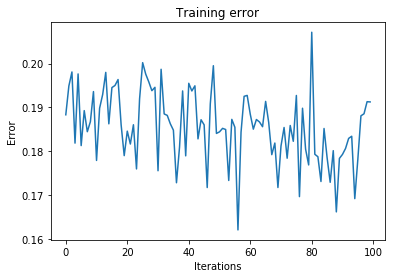

In [77]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure( )
    #fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    #loc = ticker.MultipleLocator(base=0.2)
    #ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.title('Training error')
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    #plt.axis('off')
    plt.show()


showPlot(plot_losses)